In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from datetime import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, TimeDistributed, Bidirectional
from tensorflow.keras.models import model_from_json

2025-02-08 20:25:11.135278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-08 20:25:11.167108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-08 20:25:11.167153: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 20:25:11.186689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 20:25:12.321947: W tensorflow/com

In [3]:
df = pd.read_csv("/home/ertugrulgul/Belgeler/GitHub/hakkari_test/data_H/Modellemeler/haftalıkveriler/hakkari.csv")

In [4]:
df['t2m'] = df['t2m'] - 273.15
df['tp'] = df['tp']*1000
df['sp'] = df['sp']/100
df["lat"] = df["latitude"]
df["lon"] = df["longitude"]

In [5]:
df.head()

,valid_time,latitude,longitude,number,expver,sp,u10,v10,t2m,tp,lat,lon
0,1940-01-01,37.79,43.31,0,1,743.2331,-0.022367,0.895051,-9.63218,3.649931,37.79,43.31
1,1940-01-01,37.79,43.56,0,1,738.1231,0.267427,0.899629,-9.96226,3.266792,37.79,43.56
2,1940-01-01,37.79,43.81,0,1,741.4831,0.536531,0.814057,-9.96810,2.750378,37.79,43.81
3,1940-01-01,37.79,44.06,0,1,747.8381,0.755526,0.678315,-9.95396,2.303939,37.79,44.06
4,1940-01-01,37.79,44.31,0,1,756.9931,0.824984,0.797151,-9.52866,1.858692,37.79,44.31


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49931 entries, 0 to 49930
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   valid_time  49931 non-null  object 
 1   latitude    49931 non-null  float64
 2   longitude   49931 non-null  float64
 3   number      49931 non-null  int64  
 4   expver      49931 non-null  int64  
 5   sp          49931 non-null  float64
 6   u10         49931 non-null  float64
 7   v10         49931 non-null  float64
 8   t2m         49931 non-null  float64
 9   tp          49931 non-null  float64
 10  lat         49931 non-null  float64
 11  lon         49931 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 4.6+ MB


In [7]:
df.describe()

,latitude,longitude,number,expver,sp,u10,v10,t2m,tp,lat,lon
count,49931.000000,49931.000000,49931.0,49931.0,49931.000000,49931.000000,49931.000000,49931.000000,49931.000000,49931.000000,49931.000000
mean,37.040000,44.060000,0.0,1.0,856.072539,-0.079665,-0.101981,11.857726,2.324937,37.040000,44.060000
std,0.500005,0.500005,0.0,0.0,70.262460,0.521551,0.536482,11.170519,2.448767,0.500005,0.500005
min,36.290000,43.310000,0.0,1.0,733.314400,-1.893168,-1.862009,-15.085300,0.000000,36.290000,43.310000
25%,36.540000,43.560000,0.0,1.0,794.367825,-0.434193,-0.484273,2.975250,0.196071,36.540000,43.560000
50%,37.040000,44.060000,0.0,1.0,845.616900,-0.133927,-0.152884,11.676170,1.570288,37.040000,44.060000
75%,37.540000,44.560000,0.0,1.0,918.284400,0.240395,0.231908,20.518825,3.769358,37.540000,44.560000
max,37.790000,44.810000,0.0,1.0,987.033750,2.379473,1.873778,37.649560,15.525721,37.790000,44.810000


In [8]:
df.isna().sum()

valid_time    0
latitude      0
longitude     0
number        0
expver        0
sp            0
u10           0
v10           0
t2m           0
tp            0
lat           0
lon           0
dtype: int64

In [9]:
print(df.columns)

Index(['valid_time', 'latitude', 'longitude', 'number', 'expver', 'sp', 'u10',
       'v10', 't2m', 'tp', 'lat', 'lon'],
      dtype='object')


In [10]:
# Tarih indeksini datetime formatına çevir
df['valid_time'] = pd.to_datetime(df['valid_time'])  # Tarih formatına çevir
df.set_index('valid_time', inplace=True)  # İndeks olarak ayarla
df = df.sort_index()  # Zaman sırasına göre sıralayın (bazı algoritmalar için önemli)

# Enlem ve boylam bazında gruplama yaparak her bir bölge için veri oluştur
grouped = df.groupby(["latitude", "longitude"])

In [11]:
print(df.columns)

Index(['latitude', 'longitude', 'number', 'expver', 'sp', 'u10', 'v10', 't2m',
       'tp', 'lat', 'lon'],
      dtype='object')


In [12]:
# Her grup için "valid_time" sütununun korunmasını sağlıyoruz
for (lat, lon), group in grouped:
    print(f"\n📌 İşlenen Lokasyon: ({lat}, {lon})")

    # Lokasyon bazlı DataFrame oluştur
    location_df = group.copy()

    # Tarih indeksini geri getir
    location_df = location_df.reset_index().set_index("valid_time").sort_index()

    print(location_df.head())  # İlk 5 satırı göster


📌 İşlenen Lokasyon: (36.29, 43.31)
            latitude  longitude  number  expver        sp       u10       v10  \
valid_time                                                                      
1940-01-01     36.29      43.31       0       1  980.5481 -0.988188 -0.471526   
1940-02-01     36.29      43.31       0       1  980.8906 -0.870435 -0.713150   
1940-03-01     36.29      43.31       0       1  980.9400 -0.355229 -0.521831   
1940-04-01     36.29      43.31       0       1  978.4150 -1.081098 -0.746021   
1940-05-01     36.29      43.31       0       1  974.8544  0.391407 -0.652682   

                 t2m        tp    lat    lon  
valid_time                                    
1940-01-01   6.56410  1.861673  36.29  43.31  
1940-02-01   8.69790  1.995529  36.29  43.31  
1940-03-01   9.31460  1.552368  36.29  43.31  
1940-04-01  18.52090  3.030076  36.29  43.31  
1940-05-01  23.44595  0.021438  36.29  43.31  

📌 İşlenen Lokasyon: (36.29, 43.56)
            latitude  longitude

In [13]:
for (lat, lon), group in grouped:
    print(f"\n📌 Lokasyon: ({lat}, {lon}) için veri işleniyor...")
    print(group.columns)  # Sütunları göster
    break  # Sadece ilk grup için kontrol et


📌 Lokasyon: (36.29, 43.31) için veri işleniyor...
Index(['latitude', 'longitude', 'number', 'expver', 'sp', 'u10', 'v10', 't2m',
       'tp', 'lat', 'lon'],
      dtype='object')


In [14]:
'''
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

for (lat, lon), group in grouped:
    print(f"\n📌 SARIMA Modeli Eğitiliyor: ({lat}, {lon})")

    # Lokasyon bazlı DataFrame
    location_df = group.copy().reset_index()  # "valid_time" sütununu geri getir
    location_df = location_df.set_index("valid_time").sort_index()
    
    # Günlük frekans ayarla
    location_df = location_df.asfreq("D")

    # Eksik günleri doldur
    location_df.ffill(inplace=True)

    # SARIMA Modeli (Trend + Mevsimsellik İçin)
    model = SARIMAX(location_df["t2m"], order=(3,1,3), seasonal_order=(1,1,1,12))
    model_fit = model.fit()

    # 30 Günlük Tahmin Yap
    forecast = model_fit.forecast(steps=30)

    # Tahminleri Görselleştir
    plt.figure(figsize=(10,4))
    plt.plot(location_df.index, location_df["t2m"], label="Gerçek Sıcaklık")
    plt.plot(pd.date_range(location_df.index[-1], periods=30, freq="D"), forecast, label="Tahmin", color="red")
    plt.title(f"SARIMA Tahmini - ({lat}, {lon})")
    plt.xlabel("Tarih")
    plt.ylabel("Sıcaklık")
    plt.legend()
    plt.show()
    '''

'\nfrom statsmodels.tsa.statespace.sarimax import SARIMAX\nimport matplotlib.pyplot as plt\n\nfor (lat, lon), group in grouped:\n    print(f"\n📌 SARIMA Modeli Eğitiliyor: ({lat}, {lon})")\n\n    # Lokasyon bazlı DataFrame\n    location_df = group.copy().reset_index()  # "valid_time" sütununu geri getir\n    location_df = location_df.set_index("valid_time").sort_index()\n    \n    # Günlük frekans ayarla\n    location_df = location_df.asfreq("D")\n\n    # Eksik günleri doldur\n    location_df.ffill(inplace=True)\n\n    # SARIMA Modeli (Trend + Mevsimsellik İçin)\n    model = SARIMAX(location_df["t2m"], order=(3,1,3), seasonal_order=(1,1,1,12))\n    model_fit = model.fit()\n\n    # 30 Günlük Tahmin Yap\n    forecast = model_fit.forecast(steps=30)\n\n    # Tahminleri Görselleştir\n    plt.figure(figsize=(10,4))\n    plt.plot(location_df.index, location_df["t2m"], label="Gerçek Sıcaklık")\n    plt.plot(pd.date_range(location_df.index[-1], periods=30, freq="D"), forecast, label="Tahmin", co

In [15]:
df.dtypes

latitude     float64
longitude    float64
number         int64
expver         int64
sp           float64
u10          float64
v10          float64
t2m          float64
tp           float64
lat          float64
lon          float64
dtype: object

In [16]:
print(type(df.index))  # İndeksin türünü kontrol et
print(df.index.dtype)  # İndeksin veri tipini kontrol et

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
datetime64[ns]


In [17]:
df_daily = df.resample('D').mean()
df_weekly = df.resample('W').mean()
df_month = df.resample('ME').mean()
df_year = df.resample ('YE').mean()

In [18]:
# Tarih aralıklarını kontrol et
print(df.index.min(), df.index.max())  # Veri setinin başlangıç ve bitiş tarihleri
print(df.index.to_series().diff().value_counts())  # Zaman aralıklarının düzenliliğini kontrol et

1940-01-01 00:00:00 2024-11-01 00:00:00
valid_time
0 days     48912
31 days      594
30 days      339
28 days       63
29 days       22
Name: count, dtype: int64


In [19]:
#IQR Yöntemiyle Aykırı Değerleri CSV'ye Kaydetme

# Sayısal sütunları seç
numeric_cols = df.select_dtypes(include=["number"]).columns  

# Aykırı değerleri saklamak için boş bir DataFrame oluştur
outliers_df = pd.DataFrame()

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75)  
    IQR = Q3 - Q1  

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Aykırı değerleri belirle
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].copy()  

    if not outliers.empty:
        print(f"\n📌 {col} sütunundaki aykırı değerler:")
        print(f"🔹 Alt sınır: {lower_bound:.2f}, Üst sınır: {upper_bound:.2f}")
        print(outliers[[col]])  # Sadece ilgili sütunu göster

        # ✅ Hangi sütundan geldiğini belirtmek için yeni bir sütun ekleyelim
        outliers.loc[:, "Aykırı_Sütun"] = col  

        # ✅ Aykırı değerleri birleştir
        outliers_df = pd.concat([outliers_df, outliers])  

# ✅ CSV olarak kaydet (Eğer aykırı değer bulunduysa)
if not outliers_df.empty:
    outliers_df.to_csv("aykiri_veriler_IQR.csv", index=True, encoding="utf-8")
    print("✅ Aykırı değerler 'aykiri_veriler.csv' dosyasına kaydedildi!")
else:
    print("⚠️ Aykırı değer bulunamadı.")


📌 u10 sütunundaki aykırı değerler:
🔹 Alt sınır: -1.45, Üst sınır: 1.25
                 u10
valid_time          
1940-05-01  1.278461
1940-05-01  1.270435
1940-05-01  1.393848
1940-12-01  1.342197
1940-12-01  1.370578
...              ...
2023-04-01  1.554994
2023-04-01  1.305055
2023-11-01  1.304797
2023-11-01  1.348620
2024-08-01  1.307281

[534 rows x 1 columns]

📌 v10 sütunundaki aykırı değerler:
🔹 Alt sınır: -1.56, Üst sınır: 1.31
                 v10
valid_time          
1940-05-01  1.323270
1940-05-01  1.377652
1940-05-01  1.333707
1940-12-01  1.360586
1940-12-01  1.312735
...              ...
2023-04-01  1.481478
2023-04-01  1.349643
2023-06-01  1.381023
2023-06-01  1.402324
2023-06-01  1.313000

[293 rows x 1 columns]

📌 tp sütunundaki aykırı değerler:
🔹 Alt sınır: -5.16, Üst sınır: 9.13
                   tp
valid_time           
1941-01-01   9.805806
1941-01-01   9.893067
1941-01-01  10.297902
1941-01-01  10.740645
1941-01-01  10.908492
...               ...
2024-03-01  10.

In [20]:
#Z-Score Yöntemiyle Aykırı Değerleri CSV'ye Kaydetme

# Sayısal sütunları seç
numeric_cols = df.select_dtypes(include=["number"]).columns  

outliers_df = pd.DataFrame()  # Aykırı değerleri saklayacak DataFrame

threshold = 3  # Aykırılık eşiği

for col in numeric_cols:
    mean = df[col].mean()
    std_dev = df[col].std()
    z_scores = stats.zscore(df[col])

    # Aykırı değerleri belirle
    outliers = df[abs(z_scores) > threshold].copy()  

    if not outliers.empty:
        print(f"\n📌 {col} sütunundaki aykırı değerler:")
        print(f"🔹 Ortalama: {mean:.2f}, Standart Sapma: {std_dev:.2f}")
        print(f"🔹 Aykırı sınır: {mean - 3*std_dev:.2f} ile {mean + 3*std_dev:.2f}")
        print(outliers[[col]])  # Sadece ilgili sütunu göster  

        # ✅ Hangi sütundan geldiğini ekleyelim
        outliers.loc[:, "Aykırı_Sütun"] = col  

        # ✅ Aykırı değerleri ana DataFrame'e ekleyelim
        outliers_df = pd.concat([outliers_df, outliers])  

# ✅ CSV olarak kaydet
if not outliers_df.empty:
    outliers_df.to_csv("aykiri_veriler_zscore.csv", index=True, encoding="utf-8")
    print("✅ Aykırı değerler 'aykiri_veriler_zscore.csv' dosyasına kaydedildi!")
else:
    print("⚠️ Aykırı değer bulunamadı.")


📌 u10 sütunundaki aykırı değerler:
🔹 Ortalama: -0.08, Standart Sapma: 0.52
🔹 Aykırı sınır: -1.64 ile 1.48
                 u10
valid_time          
1941-07-01  1.834359
1942-07-01  1.658861
1946-08-01 -1.748942
1946-08-01 -1.893168
1946-08-01 -1.800975
...              ...
2021-09-01  1.652991
2022-06-01  1.499895
2022-08-01  1.897367
2022-08-01  1.507108
2023-04-01  1.554994

[99 rows x 1 columns]

📌 v10 sütunundaki aykırı değerler:
🔹 Ortalama: -0.10, Standart Sapma: 0.54
🔹 Aykırı sınır: -1.71 ile 1.51
                 v10
valid_time          
1942-08-01  1.514565
1943-07-01  1.659548
1943-07-01  1.659426
1946-08-01 -1.764475
1946-08-01 -1.862009
...              ...
2021-06-01  1.588744
2021-06-01  1.544005
2022-03-01  1.625985
2022-03-01  1.694711
2022-03-01  1.579354

[70 rows x 1 columns]

📌 tp sütunundaki aykırı değerler:
🔹 Ortalama: 2.32, Standart Sapma: 2.45
🔹 Aykırı sınır: -5.02 ile 9.67
                   tp
valid_time           
1941-01-01   9.805806
1941-01-01   9.893067
1

In [21]:
import pandas as pd

# Başlangıçtaki satır sayısını kaydet
initial_rows = df.shape[0]  

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]  # Aykırı değerleri kaldır

# Silinen satır sayısını hesapla
deleted_rows = initial_rows - df.shape[0]

# Çıktı oluştur
if deleted_rows > 0:
    print(f"✅ {deleted_rows} aykırı değer başarıyla silindi!")
else:
    print("⚠️ Silinecek aykırı değer bulunamadı.")

✅ 1602 aykırı değer başarıyla silindi!


In [22]:
import pandas as pd
from scipy import stats

# Başlangıçtaki satır sayısını kaydet
initial_rows = df.shape[0]

threshold = 3  # Aykırılık sınırı

# Tüm sütunlarda aykırı olan satırları saklamak için boş bir liste
outlier_indices = set()

# 1️⃣ HER SÜTUN İÇİN AYKIRI SATIRLARI TESPİT ET
for col in numeric_cols:
    z_scores = stats.zscore(df[col])
    outliers = df.index[abs(z_scores) > threshold]  # Aykırı satırların index'leri
    outlier_indices.update(outliers)  # Set içine ekleyerek tekrarları önlüyoruz

# 2️⃣ SADECE TEK SEFERDE AYKIRI SATIRLARI SİL
df = df.drop(index=outlier_indices)

# Silinen satır sayısını hesapla
deleted_rows = initial_rows - df.shape[0]

# Çıktı oluştur
if deleted_rows > 0:
    print(f"✅ {deleted_rows} aykırı değer başarıyla silindi!")
else:
    print("⚠️ Silinecek aykırı değer bulunamadı.")

✅ 2243 aykırı değer başarıyla silindi!


In [23]:
df.head()

,latitude,longitude,number,expver,sp,u10,v10,t2m,tp,lat,lon
valid_time,,,,,,,,,,,
1940-01-01,37.79,43.31,0,1,743.2331,-0.022367,0.895051,-9.63218,3.649931,37.79,43.31
1940-01-01,37.79,43.56,0,1,738.1231,0.267427,0.899629,-9.96226,3.266792,37.79,43.56
1940-01-01,37.79,43.81,0,1,741.4831,0.536531,0.814057,-9.96810,2.750378,37.79,43.81
1940-01-01,37.79,44.06,0,1,747.8381,0.755526,0.678315,-9.95396,2.303939,37.79,44.06
1940-01-01,37.79,44.31,0,1,756.9931,0.824984,0.797151,-9.52866,1.858692,37.79,44.31


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46086 entries, 1940-01-01 to 2024-11-01
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   46086 non-null  float64
 1   longitude  46086 non-null  float64
 2   number     46086 non-null  int64  
 3   expver     46086 non-null  int64  
 4   sp         46086 non-null  float64
 5   u10        46086 non-null  float64
 6   v10        46086 non-null  float64
 7   t2m        46086 non-null  float64
 8   tp         46086 non-null  float64
 9   lat        46086 non-null  float64
 10  lon        46086 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.2 MB


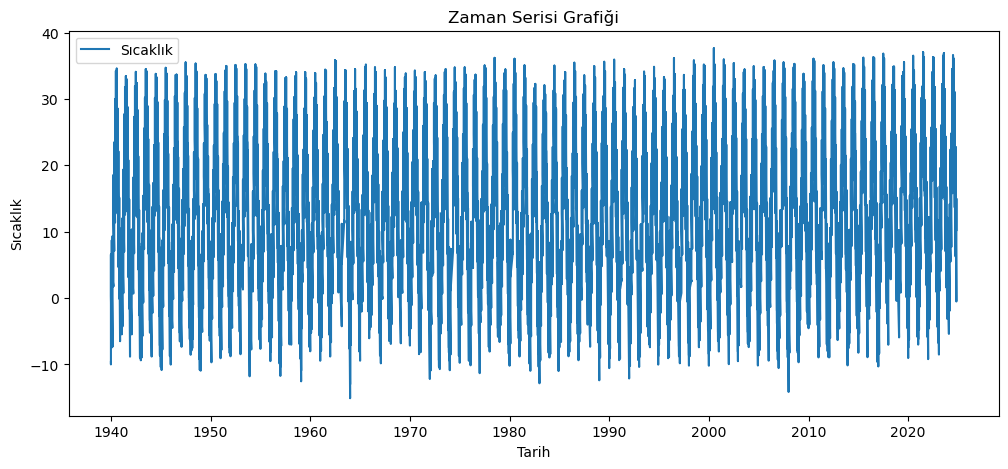

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df["t2m"], label="Sıcaklık")
plt.title("Zaman Serisi Grafiği")
plt.xlabel("Tarih")
plt.ylabel("Sıcaklık")
plt.legend()
plt.show()

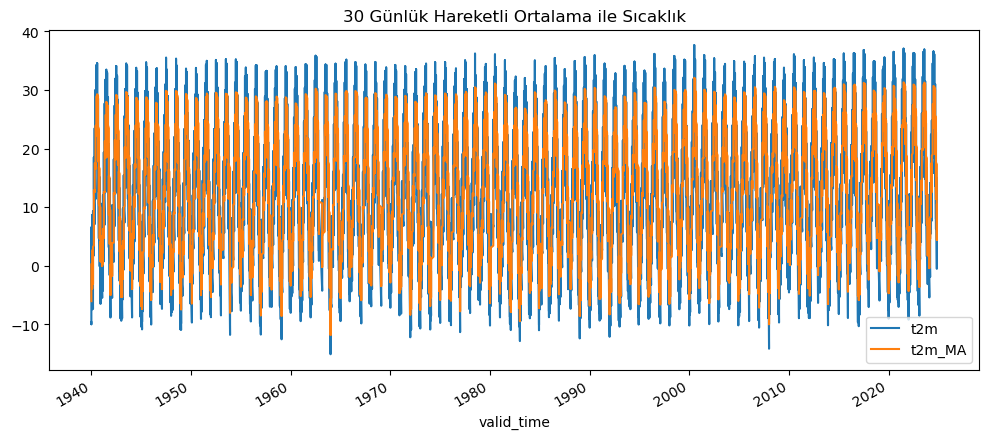

In [26]:
df["t2m_MA"] = df["t2m"].rolling(window=30).mean()  # 30 günlük ortalama
df[["t2m", "t2m_MA"]].plot(figsize=(12,5))
plt.title("30 Günlük Hareketli Ortalama ile Sıcaklık")
plt.show()

In [27]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["t2m"].dropna())  # NaN'leri çıkar
print(f"ADF Test p-değeri: {result[1]}")
if result[1] < 0.05:
    print("✅ Zaman serisi durağan (stationary).")
else:
    print("⚠️ Zaman serisi durağan değil, fark alma işlemi gerekebilir.")

ADF Test p-değeri: 2.288713269723071e-30
✅ Zaman serisi durağan (stationary).


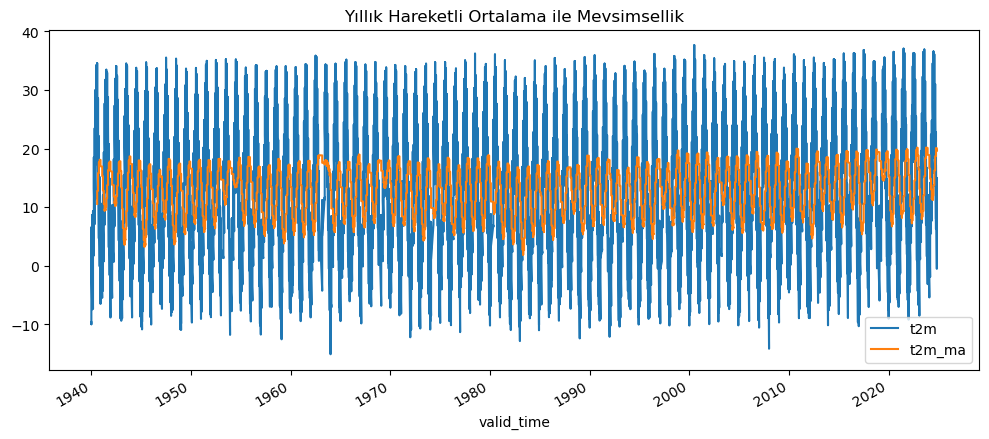

In [29]:
df["t2m_ma"] = df["t2m"].rolling(window=365).mean()  # Yıllık hareketli ortalama
df[["t2m", "t2m_ma"]].plot(figsize=(12,5))
plt.title("Yıllık Hareketli Ortalama ile Mevsimsellik")
plt.show()

<Figure size 1200x800 with 0 Axes>

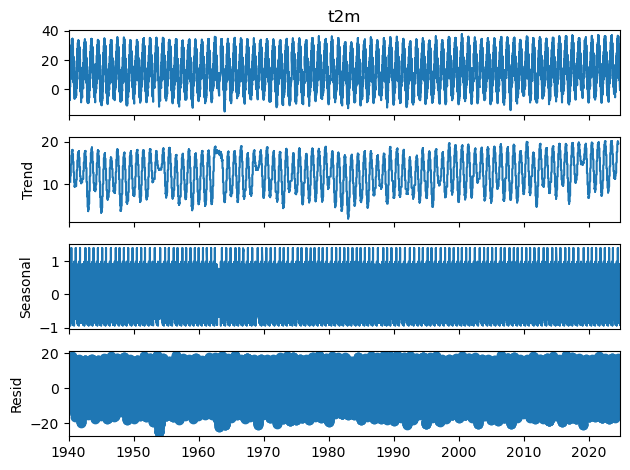

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(df["t2m"], model="additive", period=365)  # Günlük veriler için 1 yıl = 365 gün

plt.figure(figsize=(12, 8))
decompose_result.plot()
plt.show()